# Creación de la medida de negatividad y Medida de etnrelazamiento en funciónnde los estados GHZ:

Negatividad:

$$N(\rho) = \frac{1}{2} (||\rho^{\Gamma_A} ||_1 - 1  ) \$$

where $\rho^{\Gamma_A}$ is the partial trace

$||X||_1 = Tr|X| = Tr \sqrt{X^{\dagger}$X}

con ello, por el teo espectral, tenemos que:

$$\mathcal{N}(\rho) = \Sigma_i \frac{|\lambda_i|-\lambda}{2} $$

def la negatividad logaritmica:

$$E_N ( \rho) = \log_2||\rho^{\Gamma_A}||_1$$

and 

$$E_N = \log_2(2 \mathcal{N}(\rho) + 1)

In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace

from qiskit.circuit import QuantumCircuit

def Bipartite_Negativity(DensMtx : DensityMatrix):
    
    #sacamos la info de nuestro op densidad

    matrix_nparray = DensMtx.data

    #calculamos autovalores y autovectores:
    evalues, evectors = np.linalg.eig(matrix_nparray)

    #empezamos a sumar
    N = 0

    for lambdai in evalues:
        term = ( np.abs(np.real(lambdai)) - np.real(lambdai) ) / 2 #what happens when 
        # due to numerical errors, lambda_i is complex?

        #what does it means that the negativity has a complex value??¿
        #print(term)
        N += term
    


    return N    

def Multi_Partite_Negativity(cirq : QuantumCircuit):

    DensMtx = DensityMatrix(cirq)
    qubits_list = cirq.qregs

    matrix_nparray = DensMtx.data

    #for multi partite systems:
    #take the max from it

    num_qb = cirq.num_qubits
    mx = 0 
    for i in range(num_qb):
        for j in range(i): #cond j < i: R_{ij} = R_{ji} #partial trace of everythinf except the qubits ij
    
            pair = (i, j)

            list_qb_measure = [k for k in range(num_qb) if k not in pair]
            Pt_ij = partial_trace(DensMtx, list_qb_measure)

            neg_ij = Bipartite_Negativity(Pt_ij)

            if neg_ij > mx:
                mx = neg_ij

    return mx        

def Log_Negativity(cirq : QuantumCircuit):
    n = Multi_Partite_Negativity(cirq)
    return np.log2(2 * n + 1 )







# Adicionalmente, vamos a construir la medida GHZ:

Una medida de entrelazmiento que es para ver que tanto se parece a un estado GHZ, es hacerlo de la sgte manera:

$$\mu( | \Psi \rangle ) = \max_{\{U_i \}_{i=1}^n \in \mathcal{U(2)}} {(\langle GHZ_n | U_1 \otimes U_2 \otimes \cdots \otimes U_n | \Psi \rangle })$$

where $|GHZ_n \rangle = \frac{1}{\sqrt{2}}( |0^n\rangle  + |1^n\rangle)$

In [2]:
from qiskit.quantum_info.operators import Operator



def parametriced_unitary(a, b, p, t):

    za = np.exp(1j * a)
    zb = np.exp(1j * b)

    Cos_t = np.cos(t)
    Sen_t = np.sin(t)

    zp = np.exp(1j * p)

    u = Operator([[za * Cos_t, zb * Sen_t],
                  [- np.conjugate(zb) * Sen_t, np.conjugate(za) * Cos_t]])


    return u


def apply_2_ansatz_i(u, ansatz, i):

    return ansatz.append(u, [i])






def ghz_entanglement_measure(cirq : QuantumCircuit):
    #we defined in this way because we want the state from
    #the optimiced Circuit for the Ansatz...
    
    n = cirq.num_qubits

    Psi = Statevector(cirq)

    labels = [1 / np.sqrt(2)]


    for _ in range(n ** 2 - 3):
        labels.append(0)
    
    labels.append(1 / np.sqrt(2))

    
    cirq_ghz = QuantumCircuit(n)

    cirq_ghz.x(0)
    for i in range(0, n - 1):
        cirq_ghz.cx(i, i+1)
    

    GHZ_state = Statevector(cirq_ghz)

    return GHZ_state.inner(Psi)





/home/herbert/VQE_thesis/VQE1/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/herbert/VQE_thesis/VQE1/lib/python3.12/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/herbert/VQE_thesis/VQE1/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


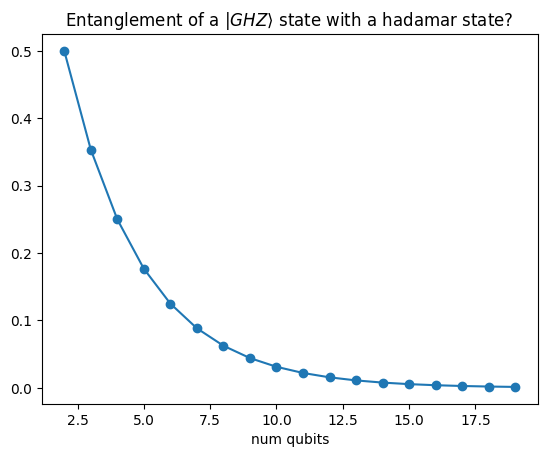

In [4]:
import matplotlib.pyplot as plt

ent = []
xcord = range(2, 20)
for x in xcord:
    qc = QuantumCircuit(x)

    qc.h(range(x))
    ent.append(ghz_entanglement_measure(qc))


plt.scatter(xcord, ent)

plt.plot(xcord, ent)

plt.title(r'Entanglement of a $|GHZ \rangle$ state with a hadamar state?')
plt.xlabel(r'num qubits')


plt.show()



# MEME


In [5]:


d= 0.75


driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto-3g")
problem = driver.run()
offset = problem.nuclear_repulsion_energy
#fc_transformer = FreezeCoreTransformer(remove_orbitals=[4, 5])

#problem = fc_transformer.transform(full_problem)

mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        ),
                )
offset = problem.nuclear_repulsion_energy
vqe = VQE(Estimator(), ansatz, SLSQP())


initial_point = HFInitialPoint()
initial_point.ansatz = ansatz
initial_point.problem = problem
vqe.initial_point = initial_point.to_numpy_array()

solver = GroundStateEigensolver(mapper, vqe)



#print(problem)
result = solver.solve(problem)
#print(f"Total ground state energy = {result.total_energies[0]:.4f}")
#energies1.append(result.total_energies[0] + offset)
#energiesH2.append(result.total_energies[0])

#print(result)

cirq = result.groundstate[0]
opt_param = result.groundstate[1]

rho = DensityMatrix(cirq.assign_parameters(opt_param))

#rho.draw('latex')

def Negativity(DensMtx):
    
    matrix_nparray = DensMtx.data

    evalues, evectors = np.linalg.eig(matrix_nparray)
    N = 0

    for lambdai in evalues:
        term = ( np.abs(np.real(lambdai)) - np.real(lambdai) ) / 2
        #print(term)
        N += term
    
    return N

neg = Negativity(rho)


#print(rho.data)




# -------------------------------------------------------------------------

# Simulación para $H_2$

In [3]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit.quantum_info import entropy


Entropy = []
Negativities = []
energiesH2 = []
energiesH1= []



for i, d in enumerate(np.arange(0.05, 2.5, 0.05)):
    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto-3g")
    problem = driver.run()
    offset = problem.nuclear_repulsion_energy
    #fc_transformer = FreezeCoreTransformer(remove_orbitals=[4, 5])

    #problem = fc_transformer.transform(full_problem)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))
    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    offset = problem.nuclear_repulsion_energy
    vqe = VQE(Estimator(), ansatz, SLSQP())

    from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    from qiskit_nature.second_q.algorithms import GroundStateEigensolver
    solver = GroundStateEigensolver(mapper, vqe)

    #print(problem)
    result = solver.solve(problem)
    #print(f"Total ground state energy = {result.total_energies[0]:.4f}")
    energiesH1.append(result.total_energies[0] + offset)
    energiesH2.append(result.total_energies[0])


    cirq = result.groundstate[0]
    opt_param = result.groundstate[1]

    rho = DensityMatrix(cirq.assign_parameters(opt_param))

    Negativities.append(Negativity(rho))
    Entropy.append(entropy(rho))
    

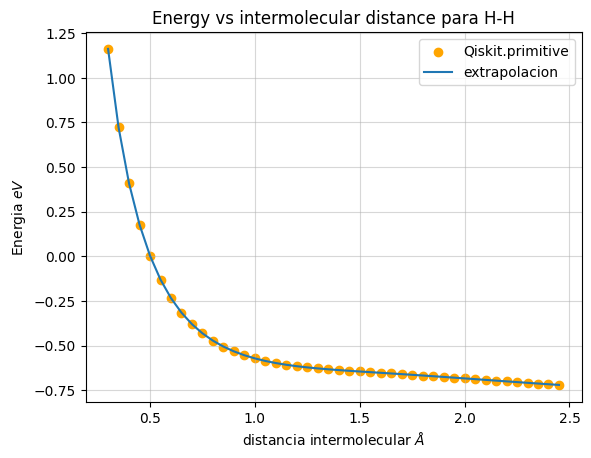

In [4]:
import matplotlib.pyplot as plt

distance = np.arange(0.05, 2.5, 0.05)

plt.scatter(distance[5:], energiesH1[5:], color='orange', label= 'Qiskit.primitive')
plt.plot(distance[5:], energiesH1[5:], label= 'extrapolacion')
plt.title(r'Energy vs intermolecular distance para H-H')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Energia $eV$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()

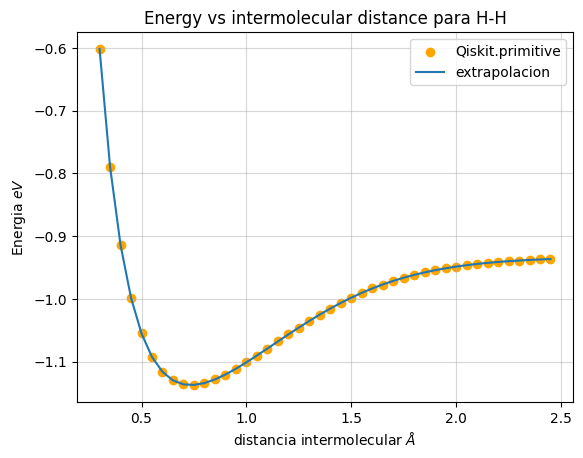

In [155]:
import matplotlib.pyplot as plt

distance = np.arange(0.05, 2.5, 0.05)

plt.scatter(distance[5:], energiesH2[5:], color='orange', label= 'Qiskit.primitive')
plt.plot(distance[5:], energiesH2[5:], label= 'extrapolacion')



plt.title(r'Energy vs intermolecular distance para H-H')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Energia $eV$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()

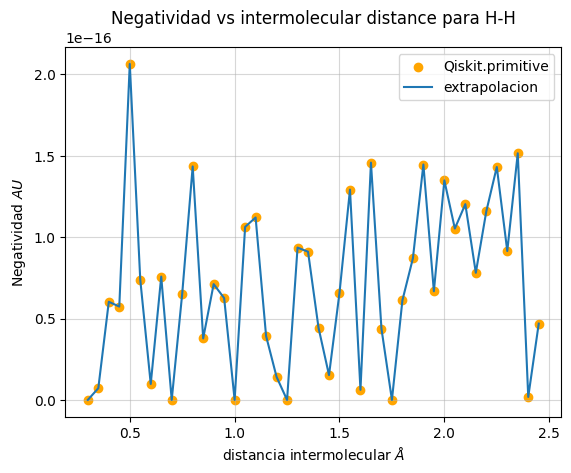

In [156]:
plt.scatter(distance[5:], Negativities[5:], color='orange', label= 'Qiskit.primitive')
plt.plot(distance[5:], Negativities[5:], label= 'extrapolacion')
plt.title(r'Negatividad vs intermolecular distance para H-H')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Negatividad $AU$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()


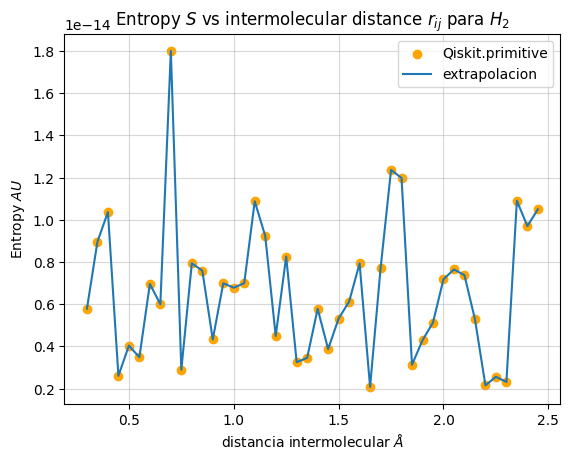

In [157]:
plt.scatter(distance[5:], Entropy[5:], color='orange', label= 'Qiskit.primitive')
plt.plot(distance[5:], Entropy[5:], label= 'extrapolacion')
plt.title(r'Entropy $S$ vs intermolecular distance $r_{ij}$ para $H_2$')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Entropy $AU$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()


# Simulation for LiH

In [45]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

EntropiesLiH = []
negativitiesLiH = []
energies1 = []
energies2 = []
for i, d in enumerate(np.arange(0.5, 4.25, 0.25)):
    driver = PySCFDriver(atom=f"Li 0 0 0; H 0 0 {d}", basis="sto-3g")
    full_problem = driver.run()
    offset = full_problem.nuclear_repulsion_energy
    fc_transformer = FreezeCoreTransformer(remove_orbitals=[4, 5])

    problem = fc_transformer.transform(full_problem)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))
    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )
    #print(ansatz.num_qubits)
    vqe = VQE(Estimator(), ansatz, SLSQP())

    from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    from qiskit_nature.second_q.algorithms import GroundStateEigensolver
    solver = GroundStateEigensolver(mapper, vqe)


    result = solver.solve(problem)
    #print(f"Total ground state energy = {result.total_energies[0]:.4f}")
    energies1.append(result.total_energies[0] + offset)
    energies2.append(result.total_energies[0])

    cirq = result.groundstate[0]
    opt_param = result.groundstate[1]

    rho = DensityMatrix(cirq.assign_parameters(opt_param))

    EntropiesLiH.append(entropy(rho))
    negativitiesLiH.append(Negativity(rho))


#por implementar: guardar estos datos en un .csv


NameError: name 'entropy' is not defined

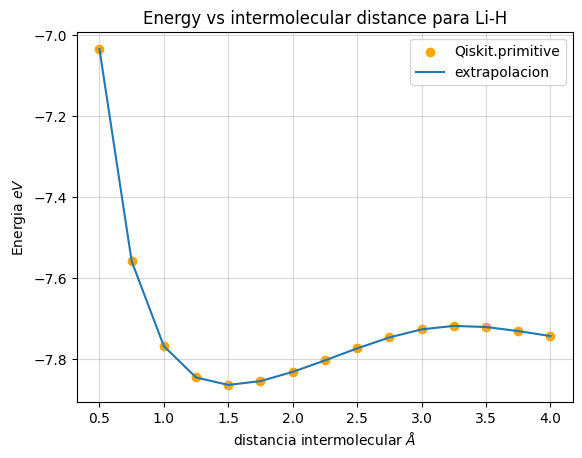

In [6]:
import matplotlib.pyplot as plt

distance = np.arange(0.5, 4.25, 0.25)

plt.scatter(distance, energies2, color='orange', label= 'Qiskit.primitive')
plt.plot(distance, energies2, label= 'extrapolacion')
plt.title(r'Energy vs intermolecular distance para Li-H')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Energia $eV$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()

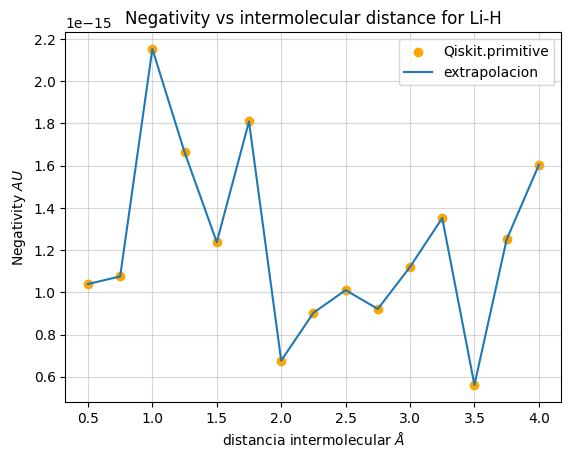

In [160]:
import matplotlib.pyplot as plt

distance = np.arange(0.5, 4.25, 0.25)

plt.scatter(distance, negativitiesLiH, color='orange', label= 'Qiskit.primitive')
plt.plot(distance, negativitiesLiH, label= 'extrapolacion')
plt.title(r'Negativity vs intermolecular distance for Li-H')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Negativity $AU$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()

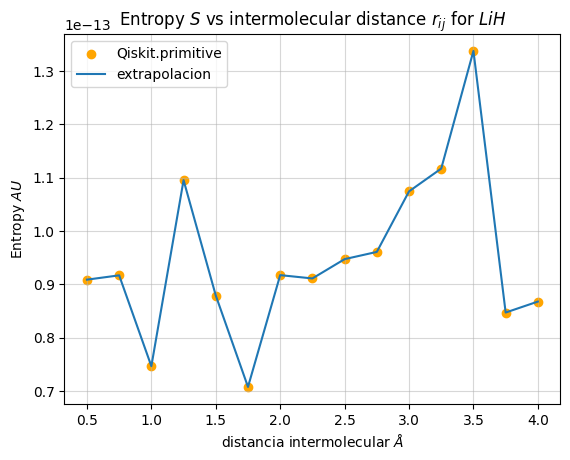

In [161]:
plt.scatter(distance, EntropiesLiH, color='orange', label= 'Qiskit.primitive')
plt.plot(distance, EntropiesLiH, label= 'extrapolacion')
plt.title(r'Entropy $S$ vs intermolecular distance $r_{ij}$ for $LiH$')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Entropy $AU$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()

# Simulation for H20

In [144]:
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer


from entanglement_measures import Multipartite_Negativity, GHZ_entanglmenetlike_measure


EntropiesH2O = []
negativitiesH2O = []
GHZ_entanglement = []
energiesH2O = []

distances = np.arange(0.05, 1.5, 0.05)
angles = np.linspace(np.pi/2, np.pi/3, num= 60)
















for i, d in enumerate(np.arange(0.05, 1.3, 0.05)):
    print(i)
    angle = np.deg2rad(104.45/2)
    xcoord = d * np.sin(angle)
    ycoord = d * np.cos(angle)

    driver = PySCFDriver(atom=f"O 0 0 0; H {-1 * xcoord} {ycoord} 0; H {xcoord} {ycoord} 0", basis="sto-3g")

    full_problem = driver.run()
    offset = full_problem.nuclear_repulsion_energy
    fc_transformer = ActiveSpaceTransformer(4, 4)

    problem = fc_transformer.transform(full_problem)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))
    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )

    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)


    result = solver.solve(problem)
    #print(f"Total ground state energy = {result.total_energies[0]:.4f}")
    #energies1.append(result.total_[0] + offset)
    energiesH2O.append(result.total_energies[0])

    cirq = result.groundstate[0]
    opt_param = result.groundstate[1]

    rho = DensityMatrix(cirq.assign_parameters(opt_param))

    EntropiesH2O.append(entropy(rho))
    negativitiesH2O.append(Negativity(rho))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


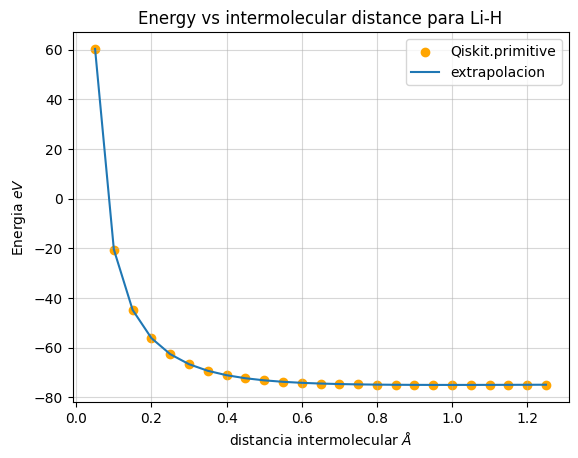

In [146]:
import matplotlib.pyplot as plt

distance = np.arange(0.05, 1.3, 0.05)

x= 0

plt.scatter(distance[x:], energiesH2O[x:], color='orange', label= 'Qiskit.primitive')
plt.plot(distance[x:], energiesH2O[x:], label= 'extrapolacion')
plt.title(r'Energy vs intermolecular distance para Li-H')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Energia $eV$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()

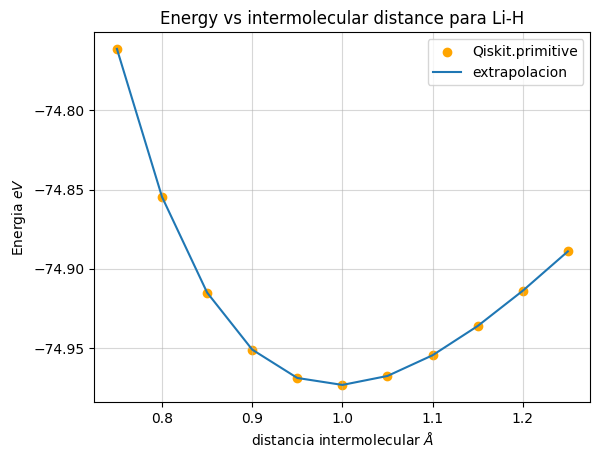

In [147]:
import matplotlib.pyplot as plt

distance = np.arange(0.05, 1.3, 0.05)

x= 14

plt.scatter(distance[x:], energiesH2O[x:], color='orange', label= 'Qiskit.primitive')
plt.plot(distance[x:], energiesH2O[x:], label= 'extrapolacion')
plt.title(r'Energy vs intermolecular distance para Li-H')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Energia $eV$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()

In [2]:
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit.quantum_info import entropy, DensityMatrix

from entanglement_measures import Multipartite_Negativity, GHZ_entanglmenetlike_measure


EntropiesH2Otwo = []
negativitiesH2Otwo = []
GHZ_entanglementtwo = []
energiesH2Otwo = []

distances = np.arange(0.05, 1.5, 0.05)
angles = np.linspace(np.pi/2, np.pi/3, num= 60)


for d in distances:
    
    row_energ = []
    row_neg = []
    row_ghz = []
    row_entropy = []

    for a in angles:

        xcoord = d * np.sin(a)
        ycoord = d * np.cos(a)

        driver = PySCFDriver(atom=f"O 0 0 0; H {-1 * xcoord} {ycoord} 0; H {xcoord} {ycoord} 0", basis="sto-3g")

        full_problem = driver.run()
        offset = full_problem.nuclear_repulsion_energy

        #we will be calculating the 2 pairs of free electrons
        fc_transformer = ActiveSpaceTransformer(4, 4)
        problem = fc_transformer.transform(full_problem)

        mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

        ansatz = UCCSD(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
            initial_state=HartreeFock(
                problem.num_spatial_orbitals,
                problem.num_particles,
                mapper,
            ),
        )

        vqe = VQE(Estimator(), ansatz, SLSQP())

        initial_point = HFInitialPoint()
        initial_point.ansatz = ansatz
        initial_point.problem = problem
        vqe.initial_point = initial_point.to_numpy_array()
        solver = GroundStateEigensolver(mapper, vqe)


        result = solver.solve(problem)
    #print(f"Total ground state energy = {result.total_energies[0]:.4f}")
    #energies1.append(result.total_[0] + offset)
        
        row_energ.append(result.total_energies[0])

        cirq = result.groundstate[0]
        opt_param = result.groundstate[1]

        final_Ansatz = cirq.assign_parameters(opt_param)

        rho = DensityMatrix(final_Ansatz)

        row_entropy.append(entropy(rho))
        row_neg.append(Multipartite_Negativity(final_Ansatz))
        row_ghz.append(GHZ_entanglmenetlike_measure(final_Ansatz))

    EntropiesH2Otwo.append(row_entropy)
    negativitiesH2Otwo.append(row_neg)
    GHZ_entanglementtwo.append(row_ghz)
    energiesH2Otwo.append(row_energ)

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3,

In [3]:
print(energiesH2Otwo)

[[58.85351186560548, 58.85372043769709, 58.8543462357875, 58.85538950637442, 58.8568506598468, 58.85873027183109, 58.86102908315809, 58.86374800079358, 58.866888098419494, 58.87045061817389, 58.87443697095014, 58.87884873853126, 58.8836876745947, 58.88895570672318, 58.89465493837183, 58.900787650414244, 58.907356304139824, 58.91436354287288, 58.9218121955621, 58.92970527865779, 58.938045999649205, 58.946837760201134, 58.956084159661984, 58.96578899859749, 58.97595628270564, 58.98659022685686, 58.997695260010616, 59.00927602912593, 59.02133740414135, 59.033884483647554, 59.04692260004413, 59.060457324690645, 59.07449447504166, 59.08904011956106, 59.10410058658846, 59.119682468343186, 59.135792631193254, 59.15243822190719, 59.16962667464685, 59.18736572373517, 59.20566340683949, 59.224528078933005, 59.243968420449136, 59.26399344877041, 59.28461252351019, 59.30583537005518, 59.3276720784916, 59.350133123594844, 59.373229377430874, 59.396972120475425, 59.42137305847943, 59.44644433828546,

In [11]:
print(negativitiesH2Otwo)

[[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j], [0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j

In [12]:
print(GHZ_entanglementtwo)

[[8.509873060858434e-07, 8.517872891405076e-07, 8.514298442378855e-07, 8.523404101291511e-07, 8.501138254197898e-07, 8.520029864822118e-07, 8.537598697057401e-07, 8.541187278176687e-07, 8.529873720289909e-07, 8.555609968604086e-07, 8.564137168970103e-07, 8.554962148557192e-07, 8.562358968924067e-07, 8.571567468102907e-07, 8.57939143222681e-07, 8.600360673545487e-07, 8.608488795100193e-07, 8.614167378779828e-07, 8.628412168909515e-07, 8.641578431963667e-07, 8.657834214397657e-07, 8.666966724784615e-07, 8.683067604494639e-07, 8.70333273363192e-07, 8.722743663432123e-07, 8.741517773282307e-07, 8.75290855565816e-07, 8.76529004222882e-07, 8.780160405570275e-07, 8.790519236626858e-07, 8.826020705488581e-07, 8.847512694869921e-07, 8.876660362019934e-07, 8.88258827336406e-07, 8.919935854898721e-07, 8.931776836150988e-07, 8.960606144703607e-07, 8.992887904981239e-07, 9.004921306164662e-07, 9.034457322311141e-07, 9.062712162557048e-07, 9.07673872330225e-07, 9.096986742955167e-07, 9.1349819269699

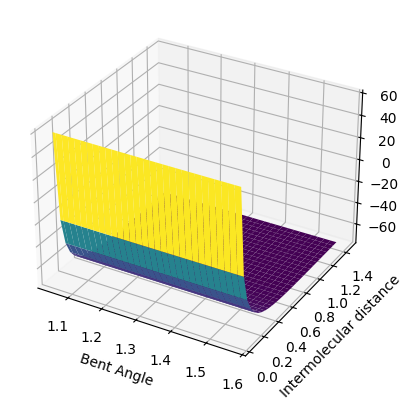

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


# Step 2: Convert the list of lists into a NumPy array
Z = np.array(energiesH2Otwo)

# Step 3: Create a meshgrid for x and y coordinates
x = angles    # Number of columns
y = distances  # Number of rows
X, Y = np.meshgrid(x, y)

# Step 4: Plot the 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Add labels (optional)
ax.set_xlabel('Bent Angle')
ax.set_ylabel('Intermolecular distance')
ax.set_zlabel('Energy')

# Show the plot
plt.show()

/home/herbert/VQE_thesis/VQE1/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/herbert/VQE_thesis/VQE1/lib/python3.12/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/herbert/VQE_thesis/VQE1/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


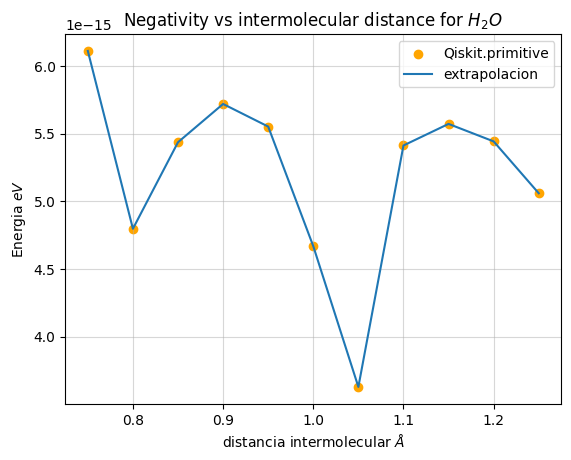

In [148]:
import matplotlib.pyplot as plt

distance = np.arange(0.05, 1.3, 0.05)

x= 14

plt.scatter(distance[x:], negativitiesH2O[x:], color='orange', label= 'Qiskit.primitive')
plt.plot(distance[x:], negativitiesH2O[x:], label= 'extrapolacion')
plt.title(r'Negativity vs intermolecular distance for $H_2O$')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Energia $eV$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()

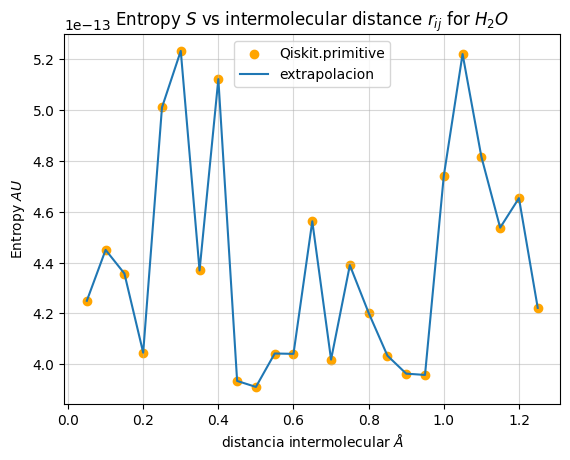

In [150]:
plt.scatter(distance, EntropiesH2O, color='orange', label= 'Qiskit.primitive')
plt.plot(distance, EntropiesH2O, label= 'extrapolacion')
plt.title(r'Entropy $S$ vs intermolecular distance $r_{ij}$ for $H_2O$')
plt.xlabel(r'distancia intermolecular $\AA$')
plt.ylabel(r'Entropy $AU$')
plt.legend()
plt.grid(alpha= 0.5)
#plt.plot(distance, energies1)
plt.show()

Simualtion for O_3

In [ ]:
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer


d = 1

alpha = np.pi
xcoord = np.cos(alpha)
ycoord = np.sin(alpha)


driver = PySCFDriver(atom=f"O 0 0 0; O {-d} 0 0; O {xcoord} {ycoord} 0", basis="sto-3g")

full_problem = driver.run()




offset = full_problem.nuclear_repulsion_energy
fc_transformer = ActiveSpaceTransformer(4, 4)

problem = fc_transformer.transform(full_problem)

mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        ),
    )

vqe = VQE(Estimator(), ansatz, SLSQP())

initial_point = HFInitialPoint()
initial_point.ansatz = ansatz
initial_point.problem = problem
vqe.initial_point = initial_point.to_numpy_array()
solver = GroundStateEigensolver(mapper, vqe)


result = solver.solve(problem)
#print(f"Total ground state energy = {result.total_energies[0]:.4f}")
#energies1.append(result.total_[0] + offset)
energiesH2O.append(result.total_energies[0])

cirq = result.groundstate[0]
opt_param = result.groundstate[1]

rho = DensityMatrix(cirq.assign_parameters(opt_param))

EntropiesH2O.append(entropy(rho))
negativitiesH2O.append(Negativity(rho))



In [49]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer


d = 1

alpha = np.pi/3
xcoord =  d * np.cos(alpha)
ycoord =  d * np.sin(alpha)


driver = PySCFDriver(atom=f"O 0 0 0; O {-d} 0 0; O {xcoord} {ycoord} 0", basis="sto-3g")



full_problem = driver.run()



ActSpaceTransformer = ActiveSpaceTransformer(18, 12)


as_problem = ActSpaceTransformer.transform(full_problem)


mapper = ParityMapper(num_particles= (as_problem.num_alpha, as_problem.num_beta))

ansatz = UCCSD(
    as_problem.num_spatial_orbitals,
    as_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        as_problem.num_spatial_orbitals,
        as_problem.num_particles,
        mapper,
        ),
    )

vqe = VQE(Estimator(), ansatz, SLSQP())

initial_point = HFInitialPoint()
initial_point.ansatz = ansatz
initial_point.problem = as_problem
vqe.initial_point = initial_point.to_numpy_array()
solver = GroundStateEigensolver(mapper, vqe)


result = solver.solve(as_problem)



KeyboardInterrupt: 

In [32]:
#ham = full_problem.hamiltonian

#sqo = ham.second_q_op()

#better_mapper.map_clifford(sqo)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIZZIZIZIIZIIZIZZIIZIZIZZIX', 'ZIIIZZZIIIZIIZIZIIIZZZIIIZIIXI', 'IIZIZIIIZIIIIIIZZIZIZZZIZZZZXX', 'ZIIIZZZIIIZIIZIZIIIZZZIIIXZZII', 'IIZIZIIIZIIIIIIZZIZIZZZIZXIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIIIXZZXI', 'ZIZIIZZIZIZIIZIIZIZZIIZIZXIIXX', 'ZIZIIZZIZIZIIZIZIZIIZXZXZIZZII', 'IIIIIIIIIIIIIIIZZZZZZXIXIIIIIX', 'IIZIZIIIZIIIIIIIIZIZIXZXZZZZXI', 'ZIIIZZZIIIZIIZIIZZZIIXIXIZIIXX', 'ZIZIIZZIZIZIIZIZIZIIXIZXZIZZII', 'IIIIIIIIIIIIIIIZZZZZXIIXIIIIIX', 'IIZIZIIIZIIIIIIIIZIZXZZXZZZZXI', 'ZIIIZZZIIIZIIZIIZZZIXZIXIZIIXX', 'ZIZIIZZIZIZIIZIXZIZZIIZXZIZZII', 'IIIIIIIIIIIIIIIXIIIIIIIXIIIIIX', 'IIZIZIIIZIIIIIIXZIZIZZZXZZZZXI', 'ZIIIZZZIIIZIIZIXIIIZZZIXIZIIXX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'ZIZIIZZIZIZIIZIIZIZZIIZIZIZIIX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIYYII', 'ZIZIIZZIZIZIIZIIZIZZIIZIZIXXIX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIXXII', 'ZIZIIZZIZIZIIZIIZIZZIIZIZIYYIX', 'IIIIIIIIIIIIIIIIIIIIIIIIYZZYII', 'ZIZIIZZIZIZIIZIIZIZZIIZIXZIXIX', 'IIIIIIIIIIIIIIIIIIIIIIIIXZZXII',

In [8]:
distances = np.arange(0.05, 1.5, 0.05)
angles = np.linspace(np.pi/2, np.pi/3, num= 60)


for d in distan

0.05 1.5707963267948966
0.1 1.5619217712762814
0.15000000000000002 1.553047215757666
0.2 1.5441726602390509
0.25 1.5352981047204357
0.3 1.5264235492018203
0.35000000000000003 1.5175489936832052
0.4 1.50867443816459
0.45 1.4997998826459746
0.5 1.4909253271273595
0.55 1.482050771608744
0.6000000000000001 1.473176216090129
0.6500000000000001 1.4643016605715138
0.7000000000000001 1.4554271050528984
0.7500000000000001 1.4465525495342832
0.8 1.437677994015668
0.8500000000000001 1.4288034384970527
0.9000000000000001 1.4199288829784376
0.9500000000000001 1.4110543274598224
1.0 1.402179771941207
1.05 1.3933052164225919
1.1 1.3844306609039765
1.1500000000000001 1.3755561053853613
1.2000000000000002 1.3666815498667462
1.2500000000000002 1.3578069943481308
1.3 1.3489324388295156
1.35 1.3400578833109005
1.4000000000000001 1.331183327792285
1.4500000000000002 1.32230877227367
